In [42]:
import CorrelationFunctions.Utilities as U
import CorrelationFunctions.Directional as D # computation along directions
import CorrelationFunctions.Map as M # correlation "maps"

using NPZ
using PyPlot
using FFTW
using Images
using CUDA
using BenchmarkTools

# Correlation functions calculated along predefined directions

In [2]:
# Load 1000^3 binary array
# Link to the data: https://www.digitalrocksportal.org/projects/317
# The data was preliminarily converted to NumPy array format
data = npzread("leopard.npy")
size(data)

(1000, 1000, 1000)

![](leopard-small.png)

The module `Directional` can calculate correlation functions along predefined directions (i.e. when a vector argument of the function is $\overline{x} = c\overline{x}_0$ where $\overline{x}$ is a predefined vector and $c$ is a scalar.

Let's calculate $S_2$ correlation function along vector $\overline{x}_0 = (1, 0, 0)$

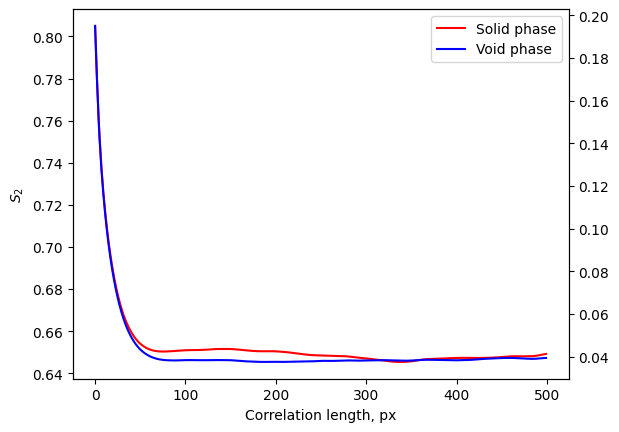

PyObject Text(26.4, 0.5, '$S_2$')

In [3]:
# periodic = false means non-periodic boundary conditions
s2_solid = D.s2(data, 1, U.DirX(); periodic = false)
s2_void = D.s2(data, 0, U.DirX(); periodic = false)
ax1 = gca()
ax2 = ax1.twinx()
(solid,) = ax1.plot(s2_solid, "r", label = "Solid phase")
(void,) = ax2.plot(s2_void, "b", label = "Void phase")
ax1.legend(handles = [solid, void])
ax1.set_xlabel("Correlation length, px")
ax1.set_ylabel(raw"$S_2$")

Calculations can be averaged across multiple dimensions

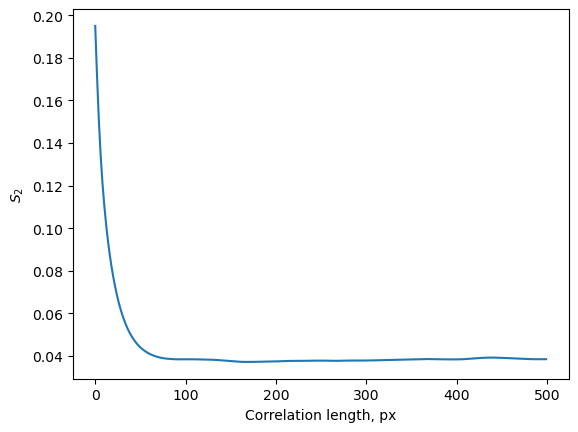

PyObject Text(26.4, 0.5, '$S_2$')

In [28]:
dirs = (U.DirX(), U.DirY(), U.DirZ())
s2avg = mapreduce(+, dirs) do dir
    D.s2(data, 0, dir; periodic = false)
end / length(dirs)
plot(s2avg)
xlabel("Correlation length, px")
ylabel(raw"$S_2$")

Before computation of surface correlation functions it's advisable to calculate $C_{0.5}$ parameter. Recommended values are 0.90-0.99. Smaller values will result in incorrect computations.

In [42]:
# Here I cut a subarray from my data because of memory limits of my PC
data = data[1:400, 1:400, 1:400]
U.lowfreq_energy_ratio(data)

0.9378294689075625

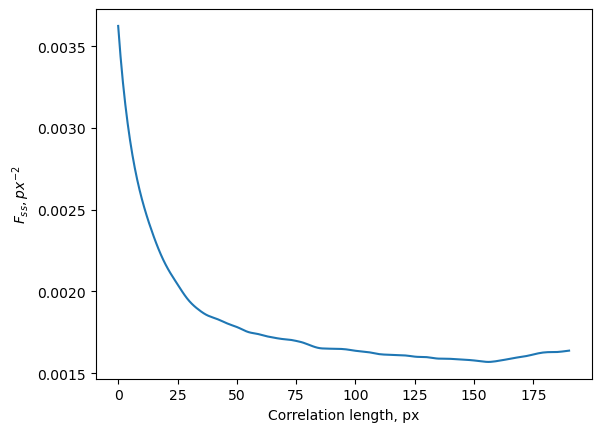

PyObject Text(31.60000000000001, 0.5, '$F_{ss}, px^{-2}$')

In [43]:
# surface-surface function averaged along axial directions
dirs = (U.DirX(), U.DirY(), U.DirZ())
fss = mapreduce(+, dirs) do dir
    D.surf2(data, 0, dir; periodic = false)
end / length(dirs)
plot(fss[10:end]) # The first ten or so points are affected by singularity at x = 0
xlabel("Correlation length, px")
ylabel(raw"$F_{ss}, px^{-2}$")

# Correlation "maps"

Now try correlation maps for two-dimensional objects (for the sake of visual clarity)

In [3]:
data = npzread("leopard.npy")[:,529,:] # Select a slice for big enough $C_{0.5}$ parameter
U.lowfreq_energy_ratio(data)

0.9112586458186104

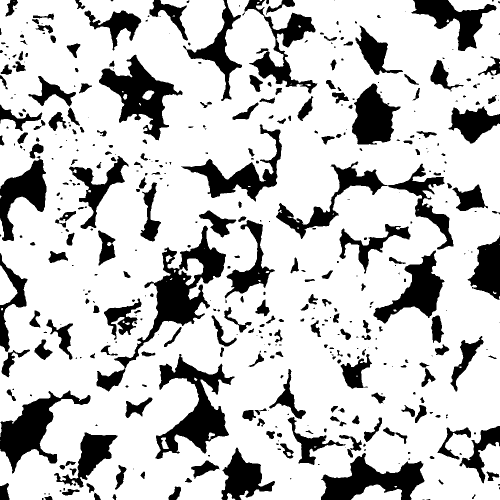

In [5]:
Gray.(imresize(data, (500, 500)))

Plot $S_2$ correlation function

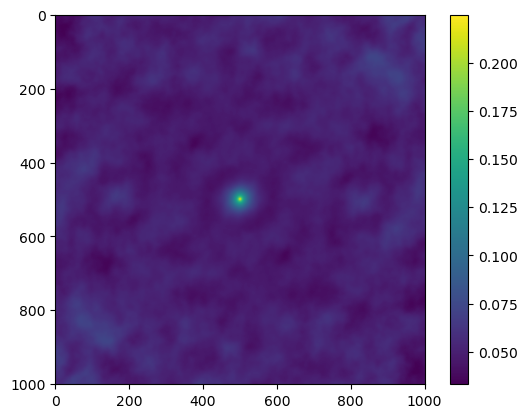

PyObject <matplotlib.colorbar.Colorbar object at 0x18ea11153ee0>

In [89]:
s2 = M.s2(data, 0; periodic = false)
# fftshift moves the origin to the center of the plot
imshow(fftshift(s2)[500:1500, 500:1500])
colorbar()

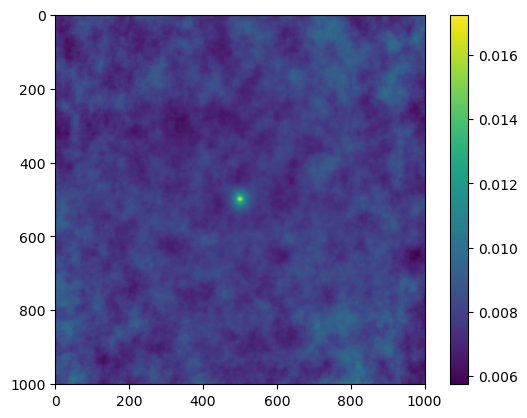

PyObject <matplotlib.colorbar.Colorbar object at 0x18ea11220640>

In [90]:
s2 = M.surfvoid(data, 0; periodic = false)
imshow(fftshift(s2)[500:1500, 500:1500])
colorbar()

# Speedup using CUDA

In [2]:
# read a subarray from a sandstone sample...
data = npzread("leopard.npy")[1:300, 1:300, 1:300]
# ...and wrap it in CuArray
cudata = CuArray(data);

In [15]:
# Comparison in speed for s2 function
#
# Here and later we use periodic boundary conditions
# because they do not require the input to be padded
# with zeros and therefore have lesser memory consumption.
@btime cf1 = M.s2(data, 1; periodic = true);
@btime cf2 = M.s2(cudata, 1; periodic = true);
cf1 ≈ Array(cf2)

  1.174 s (34 allocations: 1.42 GiB)
  267.568 μs (307 allocations: 17.19 KiB)


true

In [16]:
@btime cf1 = M.surf2(data, 1; periodic = true);
@btime cf2 = M.surf2(cudata, 1; periodic = true);
cf1 ≈ Array(cf2)

  3.616 s (131 allocations: 3.65 GiB)
  139.614 ms (664 allocations: 206.04 MiB)


true

In [18]:
@btime cf1 = M.surfvoid(data, 1; periodic = true);
@btime cf2 = M.surfvoid(cudata, 1; periodic = true);
cf1 ≈ Array(cf2)

  4.416 s (141 allocations: 4.26 GiB)
  140.147 ms (911 allocations: 206.05 MiB)


true

In [20]:
# TODO: to be optimized
@btime cf1 = M.c2(data, 1; periodic = true);
@btime cf2 = M.c2(cudata, 1; periodic = true);
cf1 ≈ Array(cf2)

  29.306 s (463 allocations: 28.95 GiB)
  7.295 s (11432 allocations: 579.25 MiB)


true

# Three-point statistics

`CorrelationFunctions.jl` can calculate correlation functions based on three-point staticstics, although much slower than two-point functions.
When calculating three-point functions, `CorrelationFunctions.jl` tries the input with a pattern consisting of three points $x_0$, $x_1$ and $x_2$.
Let $p_1 = x_1 - x_0$ and $p_2 = x_2 - x_0$. A pair $(p_1, p_2)$ is sufficient to define a trial pattern.

Any function `corrfn` based on three-point statistics accepts 4 mandatory arguments: an input array, a phase of interest, and arrays `ps1` and `ps2` 
of vectors $p_1$ and $p_2$. Each vector is an N-tuple of `Int`s where N is dimensionality of the input array. The calculation is broadcasted across 
`ps1` and `ps2` following usual rules of broadcasting.

There are predefined patterns which form right triangles parallel to one of the axes $xy$, $xz$ or $yz$.

In [26]:
# Make even smaller subarray
data = data[1:150, 1:150, 1:150]
U.lowfreq_energy_ratio(data)

0.9387524660771588

In [27]:
# For example, let's make a right triangle pattern parallel to xy
ps1, ps2 = U.right_triangles(data, U.PlaneXY())
ps1

75×75 CorrelationFunctions.Utilities.RightTrianglePattern{Tuple{Int64, Int64, Int64}}:
 (0, 0, 0)   (0, 0, 0)   (0, 0, 0)   …  (0, 0, 0)   (0, 0, 0)   (0, 0, 0)
 (1, 0, 0)   (1, 0, 0)   (1, 0, 0)      (1, 0, 0)   (1, 0, 0)   (1, 0, 0)
 (2, 0, 0)   (2, 0, 0)   (2, 0, 0)      (2, 0, 0)   (2, 0, 0)   (2, 0, 0)
 (3, 0, 0)   (3, 0, 0)   (3, 0, 0)      (3, 0, 0)   (3, 0, 0)   (3, 0, 0)
 (4, 0, 0)   (4, 0, 0)   (4, 0, 0)      (4, 0, 0)   (4, 0, 0)   (4, 0, 0)
 (5, 0, 0)   (5, 0, 0)   (5, 0, 0)   …  (5, 0, 0)   (5, 0, 0)   (5, 0, 0)
 (6, 0, 0)   (6, 0, 0)   (6, 0, 0)      (6, 0, 0)   (6, 0, 0)   (6, 0, 0)
 (7, 0, 0)   (7, 0, 0)   (7, 0, 0)      (7, 0, 0)   (7, 0, 0)   (7, 0, 0)
 (8, 0, 0)   (8, 0, 0)   (8, 0, 0)      (8, 0, 0)   (8, 0, 0)   (8, 0, 0)
 (9, 0, 0)   (9, 0, 0)   (9, 0, 0)      (9, 0, 0)   (9, 0, 0)   (9, 0, 0)
 (10, 0, 0)  (10, 0, 0)  (10, 0, 0)  …  (10, 0, 0)  (10, 0, 0)  (10, 0, 0)
 (11, 0, 0)  (11, 0, 0)  (11, 0, 0)     (11, 0, 0)  (11, 0, 0)  (11, 0, 0)
 (12, 0, 0)  (12, 0, 0)

In [28]:
ps2

75×75 CorrelationFunctions.Utilities.RightTrianglePattern{Tuple{Int64, Int64, Int64}}:
 (0, 0, 0)  (0, 1, 0)  (0, 2, 0)  …  (0, 72, 0)  (0, 73, 0)  (0, 74, 0)
 (0, 0, 0)  (0, 1, 0)  (0, 2, 0)     (0, 72, 0)  (0, 73, 0)  (0, 74, 0)
 (0, 0, 0)  (0, 1, 0)  (0, 2, 0)     (0, 72, 0)  (0, 73, 0)  (0, 74, 0)
 (0, 0, 0)  (0, 1, 0)  (0, 2, 0)     (0, 72, 0)  (0, 73, 0)  (0, 74, 0)
 (0, 0, 0)  (0, 1, 0)  (0, 2, 0)     (0, 72, 0)  (0, 73, 0)  (0, 74, 0)
 (0, 0, 0)  (0, 1, 0)  (0, 2, 0)  …  (0, 72, 0)  (0, 73, 0)  (0, 74, 0)
 (0, 0, 0)  (0, 1, 0)  (0, 2, 0)     (0, 72, 0)  (0, 73, 0)  (0, 74, 0)
 (0, 0, 0)  (0, 1, 0)  (0, 2, 0)     (0, 72, 0)  (0, 73, 0)  (0, 74, 0)
 (0, 0, 0)  (0, 1, 0)  (0, 2, 0)     (0, 72, 0)  (0, 73, 0)  (0, 74, 0)
 (0, 0, 0)  (0, 1, 0)  (0, 2, 0)     (0, 72, 0)  (0, 73, 0)  (0, 74, 0)
 (0, 0, 0)  (0, 1, 0)  (0, 2, 0)  …  (0, 72, 0)  (0, 73, 0)  (0, 74, 0)
 (0, 0, 0)  (0, 1, 0)  (0, 2, 0)     (0, 72, 0)  (0, 73, 0)  (0, 74, 0)
 (0, 0, 0)  (0, 1, 0)  (0, 2, 0)     (0, 72, 0)  

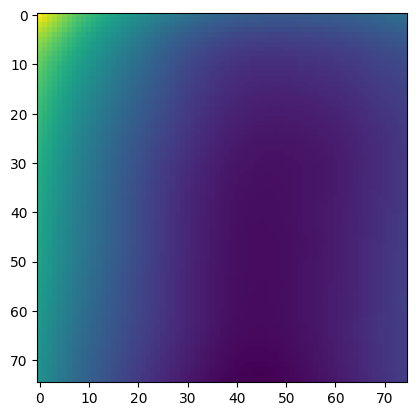

PyObject <matplotlib.image.AxesImage object at 0x72addf59d330>

In [29]:
# Now let's compute the function S_3. A computation is broadcasted across ps1 and ps2
s3 = D.s3(data, 1, ps1, ps2; periodic = false) # A keyword argument `periodic` specifies boundary conditions
imshow(s3)

## CUDA helps here a lot

In [30]:
cudata = CuArray(data);

In [38]:
@btime cf1 = D.s3(data, 1, ps1, ps2; periodic = true);
@btime cf2 = D.s3(cudata, 1, ps1, ps2; periodic = true);
cf1 ≈ Array(cf2)

  13.947 s (135013 allocations: 17.70 GiB)
  7.660 s (2124358 allocations: 117.70 MiB)


true

In [39]:
@btime cf1 = D.surf3(data, 1, ps1, ps2; periodic = true);
@btime cf2 = D.surf3(cudata, 1, ps1, ps2; periodic = true);
cf1 ≈ Array(cf2)

  92.425 s (135110 allocations: 141.81 GiB)
  12.435 s (2202889 allocations: 141.20 MiB)


true

In [40]:
@btime cf1 = D.surf2void(data, 1, ps1, ps2; periodic = true);
@btime cf2 = D.surf2void(cudata, 1, ps1, ps2; periodic = true);
cf1 ≈ Array(cf2)

  71.946 s (135116 allocations: 141.79 GiB)
  11.172 s (2356671 allocations: 174.78 MiB)


true

In [41]:
@btime cf1 = D.surfvoid2(data, 1, ps1, ps2; periodic = true);
@btime cf2 = D.surfvoid2(cudata, 1, ps1, ps2; periodic = true);
cf1 ≈ Array(cf2)

  44.823 s (135116 allocations: 141.77 GiB)
  9.390 s (2142869 allocations: 144.77 MiB)


true